# Advanced Lane Line Finding

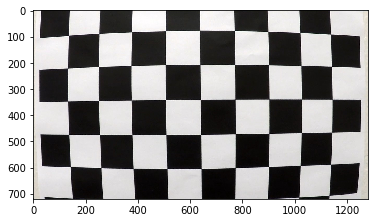

In [1]:
# import packages
import numpy as np
import cv2
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# read in sample calibration image
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

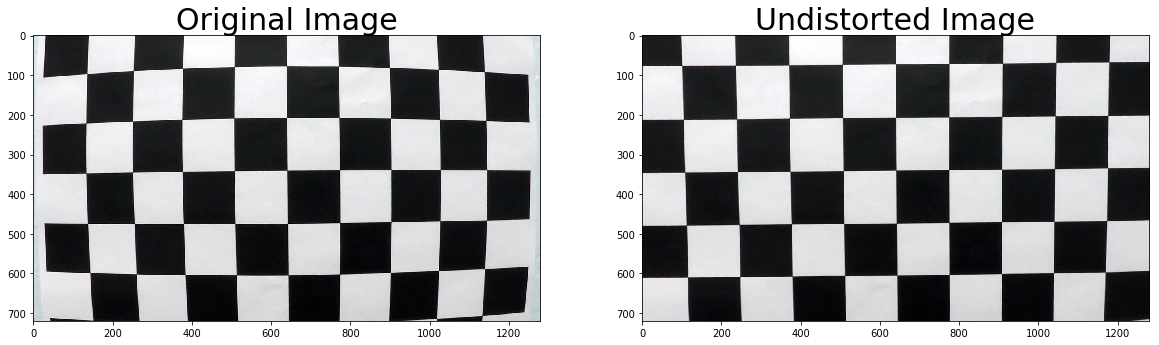

In [3]:
import glob
import pickle
import os.path
from tqdm import tqdm

sample_calibration_img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (sample_calibration_img.shape[1], sample_calibration_img.shape[0])

pickle_file_name = 'camera_distort_pickle.p'
if os.path.isfile(pickle_file_name):
    # load camera distortion matrix if already exists
    dist_pickle = pickle.load(open(pickle_file_name, 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
else:    
    nx = 9
    ny = 5
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    objpoints = []  # 3D coord in real world
    imgpoints = []  # 2D coord in image plane

    images = glob.glob('./camera_cal/calibration*.jpg')
    for file_path in tqdm(images):
        img = cv2.imread(file_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_size, None, None)

    # Save the camera calibration result for later use
    dist_pickle = {
        'mtx': mtx,
        'dist': dist,
    }
    pickle.dump(dist_pickle, open('camera_distort_pickle.p', 'wb'))

undist = cv2.undistort(sample_calibration_img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/test1_undist.jpg', undist)
    

# Visualize results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(sample_calibration_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

<function __main__.gradient_threshold>

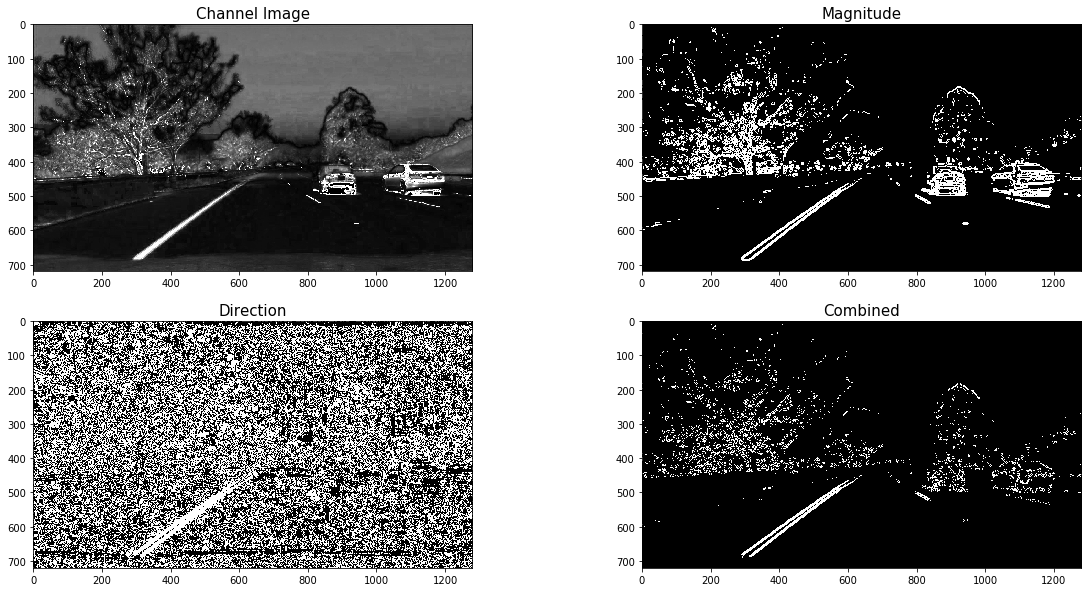

In [89]:
# Find good gradient parameters
from ipywidgets import interact
from ipywidgets.widgets import IntSlider, FloatSlider
from math import pi as PI

test_img = cv2.imread('./test_images/test6.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

def gradient_threshold(
        channel='s', mag_min=40, mag_max=255, 
        dir_min=0.45, dir_max=1.3, sobel_kernel=9):
    hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,'hls'.index(channel)]
    
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    magnitude = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    scaled = np.uint8(255*magnitude/np.max(magnitude))
    magnitude_binary = np.zeros_like(magnitude)
    mag_min = max(0, mag_min)
    mag_max = min(255, mag_max)
    magnitude_binary[(scaled >= mag_min) & (scaled <= mag_max)] = 1

    dir_min = max(0., dir_min)
    dirn_max = min(PI/2, dir_max)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    direction_binary = np.zeros_like(direction)
    direction_binary[(direction >= dir_min) & (direction <= dir_max)] = 1

    combined_binary = np.zeros_like(abs_sobelx)
    combined_binary[(magnitude_binary == 1) & (direction_binary == 1)] = 1
    
    # Visualize results
    f, axarr = plt.subplots(2, 2, figsize=(20, 10))
    axarr[0, 0].imshow(channel, cmap='gray')
    axarr[0, 0].set_title('Channel Image', fontsize=15)
    axarr[0, 1].imshow(magnitude_binary, cmap='gray')
    axarr[0, 1].set_title('Magnitude', fontsize=15)
    axarr[1, 0].imshow(direction_binary, cmap='gray')
    axarr[1, 0].set_title('Direction', fontsize=15)
    axarr[1, 1].imshow(combined_binary, cmap='gray')
    axarr[1, 1].set_title('Combined', fontsize=15)

    
interact(
    gradient_threshold,
    channel=['h', 'l', 's'],
    mag_min=IntSlider(min=0,max=255,step=1,value=40),
    mag_max=IntSlider(min=0,max=255,step=1,value=255),
    dir_min=FloatSlider(min=0.0, max=PI/2.,value=0.45),
    dir_max=FloatSlider(min=0.0, max=PI/2.,value=1.3),
    sobel_kernel=(1, 13, 2),
)

In [ ]:
def sobel(img):
    pass

def hls(img):
    pass

def rgb(img):
    pass

def perspective_transform(img):
    

def add_label(img, offset, radius):
    pass

In [ ]:
def image_pipeline(img):
    """Main pipeline that finds laneline"""
    img = np.copy(img)
    return img

test_images = glob.glob('./test_images/test*.jpg')
for img_path in test_images:
    orig_img_bgr = cv2.imread(img_path)
    orig_img = cv2.cvtColor(orig_img_bgr, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    processed_img = image_pipeline(orig_img)
    
    ax1.imshow(orig_img)
    ax1.set_title('Original Image')
    ax2.imshow(processed_img)
    ax2.set_title('Processed Image')
    plt.show()
    break  # TODO(Olala): remove this after pipeline implemented